# EECS6893 Final Project Notebook
## Sentimental Analsis

- Name: Ari Novack
- Date: 19 December 2017

## Sections
- Import Data
    - Import Census Data
        - Census API
        - File import
    - Import GeoData
        - Plotting
        - Combine with US Census Data
    - Import NYTimes Data
        - Clean and Select Data
        - Sentiment Analysis
        - Combine with US Census Data
    - PySpark
        - Put and get data from PySpark
- Data Analysis
    - Clustering
    - Predictive Modeling

## Conventions
- df: Pandas Dataframe
- gdf: GeoDataframe

In [31]:
# General imports
import pandas as pd
import os
import numpy as np
%matplotlib inline

# Import Census Data
Two techniques were used to input the Census Data into python
- census library
- file import

The census library uses the Census Bureau API, while the file import method uses datafiles that are downloaded locally. Which interface to use depends on the amount of data needed.

## Import Census Data using census library

In [364]:
from census import Census
from us import states

census_api = Census("dcbb48ad6658a04efb7be04daf62f558fe223d8f") # setup API connection using US Census Bureau API

In [365]:
# get data using the census API from all states for a data reference name (e.g. "P0010001")
# return data as a dataframe where the index is a zipcode and the data requested for each zipcode is labeled as column_name

def get_data(column_name=None, ref_name=None, numeric=True, year=None, dataset="sf1"):
    new_df = pd.DataFrame()
    for s in states.STATES:
        if dataset == "sf1":
            data = census_api.sf1.state_zipcode(['NAME', ref_name], s.fips, Census.ALL, year=year)
        elif dataset == "acs":
             data = census_api.acs.zipcode(['NAME',ref_name], Census.ALL, year=year) # Household income in past 12 months
        else:
            raise Exception
        new_df = new_df.append(data)
    
    new_df = new_df.rename(columns={'zip code tabulation area': 'zipcode'})
    new_df = new_df.set_index("zipcode")
    
    if column_name is None:
        column_name = ref_name
    
    new_df = new_df.rename(index=str, columns={ref_name: column_name})
    
    if numeric:
        new_df[column_name] = new_df[column_name].apply(pd.to_numeric)
    new_df = new_df[~new_df.index.duplicated(keep='first')] # drop duplicated zip codes (that extend over state borders)
    
    return new_df

In [366]:
# gather population data from 2010 (SF1) and data household income data 2011 and 2012 (ACS)
df1 = get_data(ref_name="P0010001", column_name="population", dataset="sf1", year=2010)
df2 = get_data(ref_name="B19013_001E", column_name="household_income_2011", dataset="acs", year=2011)
df3 = get_data(ref_name="B19013_001E", column_name="household_income_2012", dataset="acs", year=2012)


In [373]:
# combine dataframes
df = pd.concat([df1, df2, df3], axis=1)
df.head()

,NAME,population,state,household_income_2011,NAME,household_income_2012,NAME
00601,NaN,NaN,NaN,13318.0,ZCTA5 00601,13495.0,ZCTA5 00601
00602,NaN,NaN,NaN,14947.0,ZCTA5 00602,15106.0,ZCTA5 00602
00603,NaN,NaN,NaN,14437.0,ZCTA5 00603,15079.0,ZCTA5 00603
00606,NaN,NaN,NaN,11155.0,ZCTA5 00606,12098.0,ZCTA5 00606
00610,NaN,NaN,NaN,16367.0,ZCTA5 00610,16923.0,ZCTA5 00610


## Import Census Data using local datafiles

In [50]:
import os
# path containing datafiles for each state, should be in the SF1 format, e.g. "ak2010.sf1"
census_path = "/Users/ajnovack/Documents/Columbia/EECS6893/Assignments/Project/data"
print os.path.exists(census_path)

True


In [273]:
def get_zip_geoheader(datapath=None, state=None, year=2010):
    
    # check valid inputs
    if state not in states.STATES_AND_TERRITORIES:
        print "bad state {}".format(state)
        return None
       
    year = str(year)
    if year != "2010":
        # only 2010 valid right now
        print "bad year {}".format(year)
        return None

    state_df = pd.DataFrame()
    state_fips = state.fips
    state_abbr = state.abbr.lower()
    print "Loading geoheader for {}".format(state_abbr)
    
    folder_name = os.path.join(datapath,"{}{}.sf1".format(state_abbr,year))
    filename = "{}geo{}.sf1".format(state_abbr, year)
    full_filename = os.path.join(folder_name, filename)
    names = ["FILEID", "STUSAB", "SUMLEV", "GEOCOMP", "CHARITER", "CIFSN", "LOGRECNO", "ZCTA5"]
    types = [None, None, "int64", None, None, None, "int64", "int64"]
    
    geo_df = pd.read_fwf(full_filename, header=None, names=names, colspecs=[(0,6),[6,8],[8,11],[11,13],[13,16],[16,18],[18,25],[171,176]])
    geo_df = geo_df[geo_df["SUMLEV"] == 871]
    geo_df = geo_df[["LOGRECNO", "ZCTA5"]].dropna()
    return geo_df

geo_df = get_zip_geoheader(datapath=census_path, state=states.WA)
geo_df.head()


Loading geoheader for wa


,LOGRECNO,ZCTA5
227185,227186,98001.0
227187,227188,98002.0
227189,227190,98003.0
227191,227192,98004.0
227193,227194,98005.0


In [274]:
# P1, P3, P12, P16, P17, P18, P28


def load_state_datafile(datapath=None, state=None, datasets=None, year=2010):
    # Load a specified set of datasets from a specific state
    # return a dataframe with the index az zipcode and the columns as the data

    # check valid inputs
    if state not in states.STATES_AND_TERRITORIES:
        return None
    for d in datasets:
        if d not in ["P1","P3","P12","P16","P17","P18","P28"]:
            print "bad dataset {}".format(d)
            return None
        
    year = str(year)
    if year != "2010":
        # only 2010 valid right now
        print "bad year {}".format(year)
        return None
    
    state_df = pd.DataFrame()
    state_fips = state.fips
    state_abbr = state.abbr.lower()
    print "Loading {} for {}".format(datasets, state_abbr)
    
    folder_name = "/Users/ajnovack/Documents/Columbia/EECS6893/Assignments/Project/{}2010.sf1".format(state_abbr)
    folder_name = os.path.join(datapath,"{}{}.sf1".format(state_abbr,year))
    print folder_name
    
    geo_df = get_zip_geoheader(datapath=datapath, state=state) # this is used to link zipcode

    state_df = pd.DataFrame()

    if "P1" in datasets:
        # import P1
        segment_number = 1
        filename = state_abbr + "{:05d}".format(segment_number) + "2010.sf1"
        full_filename = os.path.join(folder_name, filename)
        names = ["FILEID", "STUSAB", "CHARITER", "CIFSN", "LOGRECNO"]
        REF_NAMES = ["P0010001"]
        names.extend(REF_NAMES)
        df_new = pd.read_table(full_filename, sep=',', names=names, header=None)
#         df_new = df_new.set_index(["STUSAB","LOGRECNO"]) # set key to State
        df_new = df_new.drop(columns=['FILEID', 'CHARITER', "CIFSN"])
        
        df_new = df_new[df_new["LOGRECNO"].isin(geo_df["LOGRECNO"])]
        df_new["zipcode"] = df_new.apply(lambda row: int(geo_df["ZCTA5"].where(geo_df["LOGRECNO"] == row["LOGRECNO"]).dropna().iloc[0]),axis=1)
        df_new = df_new.set_index(["zipcode"])
        
        state_df = pd.concat([state_df, df_new], axis=1)

    if "P3" in datasets:
        # import P3
        segment_number = 3
        filename = state_abbr + "{:05d}".format(segment_number) + "2010.sf1"
        full_filename = os.path.join(folder_name, filename)
        names = ["FILEID", "STUSAB", "CHARITER", "CIFSN", "LOGRECNO"]
        REF_NAMES = ["P{:03}{:04}".format(3, i+1) for i in range(0,8)]
        # print REF_NAMES
        names.extend(REF_NAMES)
        cols = [0,1,2,3,4]
        cols.extend(range(5,5+8))
        df_new = pd.read_table(full_filename, sep=',', names=names, usecols=cols, header=None)
        df_new = df_new.drop(columns=['FILEID', 'CHARITER', "CIFSN"])
        df_new = df_new[df_new["LOGRECNO"].isin(geo_df["LOGRECNO"])]
        df_new["zipcode"] = df_new.apply(lambda row: int(geo_df["ZCTA5"].where(geo_df["LOGRECNO"] == row["LOGRECNO"]).dropna().iloc[0]),axis=1)
        df_new = df_new.set_index(["zipcode"])
        state_df = pd.concat([state_df, df_new], axis=1)
    #     df = df.append(df_new)
#         df_new.head()
        
    if "P12" in datasets:
        # import P12
        segment_number = 4
        filename = state_abbr + "{:05d}".format(segment_number) + "2010.sf1"
        full_filename = os.path.join(folder_name, filename)
        names = ["FILEID", "STUSAB", "CHARITER", "CIFSN", "LOGRECNO"]
        REF_NAMES = ["P{:03}{:04}".format(12, i+1) for i in range(0,49)]
        # print REF_NAMES
        names.extend(REF_NAMES)
        cols = [0,1,2,3,4]
        cols.extend(range(5+71+73,5+71+73+49))
        df_new = pd.read_table(full_filename, sep=',', names=names, usecols=cols, header=None)
        df_new = df_new[df_new["LOGRECNO"].isin(geo_df["LOGRECNO"])]
        df_new["zipcode"] = df_new.apply(lambda row: int(geo_df["ZCTA5"].where(geo_df["LOGRECNO"] == row["LOGRECNO"]).dropna().iloc[0]),axis=1)
        df_new = df_new.set_index(["zipcode"])
        df_new = df_new.drop(columns=['FILEID', 'CHARITER', "CIFSN"])
    #     state_df = state_df.append(df_new)
        state_df = pd.concat([state_df, df_new], axis=1)
        df_new.head()

    if "P16" in datasets or "P17" in datasets or "P18" in datasets:

        # import P16, P17, P18
        segment_number = 5
        filename = state_abbr + "{:05d}".format(segment_number) + "2010.sf1"
        full_filename = os.path.join(folder_name, filename)
        names = ["FILEID", "STUSAB", "CHARITER", "CIFSN", "LOGRECNO"]
        cols = [0,1,2,3,4]

        # 16
        if "P16" in datasets:
            REF_NAMES = ["P{:03}{:04}".format(16, i+1) for i in range(0,3)]
            names.extend(REF_NAMES)
            cols.extend(range(5+17,5+17+3))
        
        if "P17" in datasets:
            # 17
            REF_NAMES = ["P{:03}{:04}".format(17, i+1) for i in range(0,3)]
            names.extend(REF_NAMES)
            cols.extend(range(5+17+3,5+17+3+3))

        if "P18" in datasets:

            # 18
            REF_NAMES = ["P{:03}{:04}".format(18, i+1) for i in range(0,9)]
            names.extend(REF_NAMES)
            cols.extend(range(5+17+3+3,5+17+3+3+9))

        df_new = pd.read_table(full_filename, sep=',', names=names, usecols=cols, header=None)
        df_new = df_new[df_new["LOGRECNO"].isin(geo_df["LOGRECNO"])]
        df_new["zipcode"] = df_new.apply(lambda row: int(geo_df["ZCTA5"].where(geo_df["LOGRECNO"] == row["LOGRECNO"]).dropna().iloc[0]),axis=1)
        df_new = df_new.set_index(["zipcode"])
        df_new = df_new.drop(columns=['FILEID', 'CHARITER', "CIFSN"])
    #     df = df.append(df_new)
        state_df = pd.concat([state_df, df_new], axis=1)
        df_new.head()

    if "P28" in datasets:

        # import P28
        segment_number = 5
        filename = state_abbr + "{:05d}".format(segment_number) + "2010.sf1"
        full_filename = os.path.join(folder_name, filename)
        names = ["FILEID", "STUSAB", "CHARITER", "CIFSN", "LOGRECNO"]
        REF_NAMES = ["P{:03}{:04}".format(28, i+1) for i in range(0,16)]
        # print REF_NAMES
        names.extend(REF_NAMES)
        cols = [0,1,2,3,4]
        cols.extend(range(5+188,5+188+16))
        df_new = pd.read_table(full_filename, sep=',', names=names, usecols=cols, header=None)
        df_new = df_new[df_new["LOGRECNO"].isin(geo_df["LOGRECNO"])]
        df_new["zipcode"] = df_new.apply(lambda row: int(geo_df["ZCTA5"].where(geo_df["LOGRECNO"] == row["LOGRECNO"]).dropna().iloc[0]),axis=1)
        df_new = df_new.set_index(["zipcode"])
        df_new = df_new.drop(columns=['FILEID', 'CHARITER', "CIFSN"])
    #     df = df.append(df_new)
        state_df = pd.concat([state_df, df_new], axis=1)
    
#     df = df.append(state_df)
    return state_df
# df.drop(columns=['FILEID', 'CHARITER', "CIFSN"])
# df.head()


In [275]:
al_df = load_state_datafile(datapath=census_path, state=states.AL, datasets=["P1","P12"], year=2010)
al_df.head()
# ak_df = load_state_datafile(datapath=census_path, state=states.AK, datasets=["P1","P12"], year=2010)
# ak_df.head()
# wa_df = load_state_datafile(datapath=census_path, state=states.WA, datasets=["P1","P12"], year=2010)
# wa_df.head()

Loading ['P1', 'P12'] for al
/Users/ajnovack/Documents/Columbia/EECS6893/Assignments/Project/data/al2010.sf1
Loading geoheader for al


,STUSAB,LOGRECNO,P0010001,STUSAB,LOGRECNO,P0120001,P0120002,P0120003,P0120004,P0120005,...,P0120040,P0120041,P0120042,P0120043,P0120044,P0120045,P0120046,P0120047,P0120048,P0120049
zipcode,,,,,,,,,,,,,,,,,,,,,
30165,AL,280911,70,AL,280911,70,33,1,2,2,...,3,5,2,1,1,3,2,1,1,2
31905,AL,280913,9,AL,280913,9,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35004,AL,280915,10427,AL,280915,10427,5037,450,333,289,...,357,355,105,183,105,144,162,119,82,52
35005,AL,280917,7942,AL,280917,7942,3806,217,259,288,...,290,293,120,131,73,129,159,135,118,93
35006,AL,280919,3121,AL,280919,3121,1594,89,108,129,...,136,109,43,61,33,54,64,36,18,19


## Import GeoPandas Data
Geopandas provides a modified Dataframe class that contains shape files for easy plotting
The shapefiles are downloaded and imported from the US Census Bureau

In [214]:
# load geopandas and import shapefiles
import geopandas as gpd

states_filename = "tl_2017_us_state.zip"
states_url = "https://www2.census.gov/geo/tiger/TIGER2017/STATE/{states_filename}".format(states_filename=states_filename)
states_file = pathlib.Path(states_filename)

zipcode_filename = "tl_2017_us_zcta510.zip"
zipcode_url = "https://www2.census.gov/geo/tiger/TIGER2017/ZCTA5/{zipcode_filename}".format(zipcode_filename=zipcode_filename)
zipcode_file = pathlib.Path(zipcode_filename)

zipcode_gdf = gpd.read_file("zip://{zipcode_file}".format(zipcode_file=zipcode_file))
states_gdf = gpd.read_file("zip://{states_file}".format(states_file=states_file))

# zipcode_gdf = zipcode_gdf.rename(columns={'GEOID10': 'zipcode'})
zipcode_gdf["zipcode"] = zipcode_gdf.apply(lambda row: int(row["GEOID10"]),axis=1)

zipcode_gdf = zipcode_gdf.set_index("zipcode")



In [248]:
# zipcode_gdf.head()
states_gdf.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62265662566,489840834,+38.6472854,-080.6183274,"POLYGON ((-81.747254 39.095379, -81.746354 39...."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138911437206,31398800291,+28.4574302,-082.4091478,"(POLYGON ((-82.987477 24.625379, -82.987477 24..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143784114293,6211277447,+40.1028754,-089.1526108,"POLYGON ((-91.185295 40.637803, -91.1751 40.64..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206229176104,18944967530,+46.3158148,-094.1996628,"POLYGON ((-96.784381 46.63050399999999, -96.78..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25150696145,6980371026,+38.9466584,-076.6744939,"POLYGON ((-77.45880799999999 39.22027, -77.458..."


## GeoPandas Plotting

In [282]:
# basic plotting for GeoPandas

def us_plot(df=None, **kwargs):
    column = df.columns[0]
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    states_gdf.plot(ax=ax, color='white', edgecolor='black')
    ax.grid(False)
    top = 49.3457868 # north lat
    left = -124.7844079 # west long
    right = -66.9513812 # east long
    bottom = 24.7433195 # south lat

    ax.set_xlim([left,right])
    ax.set_ylim([bottom,top])
    
    plot_gdf = pd.concat([zipcode_gdf, df], axis=1)
    plot_gdf = plot_gdf.dropna()
    ax = plot_gdf.plot(ax=ax, column=column, cmap='OrRd', **kwargs)
    fig.savefig("us_" + str(column))
    
def state_plot(df=None, state=None, **kwargs):
    column = df.columns[0]
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    states_gdf[states_gdf["GEOID"] == state.fips].plot(ax=ax, color='white', edgecolor='black')
    ax.grid(False)

    plot_gdf = pd.concat([zipcode_gdf, df], axis=1)
    plot_gdf = plot_gdf.dropna()
    ax = plot_gdf.plot(ax=ax, column=column, cmap='OrRd', **kwargs)
    fig.savefig("state_{}_{}".format(state.abbr.lower(), str(column)))


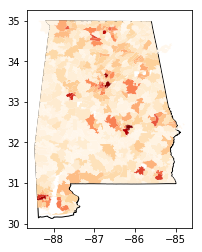

In [283]:
# us_plot(df = al_df[["P0010001"]])
state_plot(df = al_df[["P0010001"]], state=states.AL)

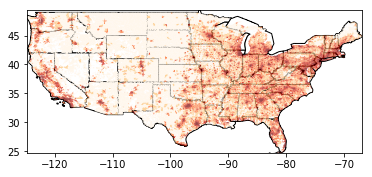

In [399]:
df.index = pd.to_numeric(df.index)
us_gdf = pd.concat([zipcode_gdf, df], axis=1)
us_gdf["pop_density"] = 10*np.log10(us_gdf["population"]/us_gdf["ALAND10"]+1) # log-scaled pop density
us_gdf = us_gdf.dropna()
us_plot(df=us_gdf[["pop_density"]], scheme='quantiles')

# NYTIMES

In [400]:
from nytimesarticle import articleAPI
api = articleAPI("e39708e22e1f4c8b8253585880c16f25")

In [401]:
from zipcode import Zip

In [402]:
import zipcode

In [403]:
articles = api.search(q=["fun", "New York, NY"],
                          # fq={"source": ["Reuters", "AP", "The New York Times"]},
                          begin_date="20000101",
                          end_date="20100101",
                          page=1)
print len(articles["response"]["docs"])
articles["response"]["docs"][0]

10


{u'_id': u'4fd397848eb7c8105d8d06d2',
 u'abstract': u"Reviews of Monday's shows gave Scorecard a flashback to Lit Theory 101. Thakoon's collaged amoeboid panels' eerie resemblance to a certain infamous instance of intellectual pilfering by the Balenciaga designer Nicolas Ghesqui\xe8re back in 2002 had the critics mussing that references had better look remixed, rather than rehashed. Meanwhile, over at the Armory, fashion's pasticheur extraordinaire's balletic riff on Japanese minimalism hit the Marc. Was that ever in doubt?",
 u'blog': {},
 u'byline': {u'organization': None,
  u'original': u'By ALISON S. COHN',
  u'person': [{u'firstname': u'Alison',
    u'lastname': u'COHN',
    u'middlename': u'S.',
    u'organization': u'',
    u'qualifier': None,
    u'rank': 1,
    u'role': u'reported',
    u'title': None}]},
 u'document_type': u'blogpost',
 u'headline': {u'content_kicker': None,
  u'kicker': u'T Magazine',
  u'main': u'Scorecard | Marc Jacobs Wins!',
  u'name': None,
  u'print_he

In [405]:
def get_news_snippets(zipcode, n_pages=2):
    # generate news snippets from NYTimes from a given zipcode
    zipcode = str(zipcode)
    city = zipcode.isequal(zipcode).city
    state = zipcode.isequal(zipcode).state
    snippets = []
    for i in range(n_pages):
        articles = api.search(q=["fun", "{city}, {state}".format(city=city, state=state)],
                              # fq={"source": ["Reuters", "AP", "The New York Times"]},
                              begin_date="20000101",
                              end_date="20100101",
                              page=i)
        try:
            for a in articles["response"]["docs"]:
                snippets.append(a['snippet'])
        except:
            pass
    return snippets

print get_news_snippets(10027)



[u'The first step to running a marathon is to choose your race.', u'A review of this week\u2019s news in New York, through the comments of City Room blog readers.', u'Newspapers such as The New York Times could better serve readers by seeking innovative ways to cope with the problems involved in covering themselves.', u'From the same-sex marriage bill, the splashdown of US Airways Flight 1549 and the Air Force One flyover, the top 10 posts that received the most comments in 2009.', u'From the same-sex marriage bill, the splashdown of US Airways Flight 1549 and the Air Force One flyover, the top 10 posts that received the most comments in 2009.', u'Jim Schachter answered questions from readers.', u'Pedro Martinez will have an implausible return to baseball\u2019s grandest stage \u2014 a Game 2 start in the World Series, against his old nemesis, at Yankee Stadium.', u'', u'AROUND TOWN.', u'Our crew of independent bloggers from the East complete their whirlwind look at the 2009-10 N.H.L. 

In [275]:
# Train the classifier

from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

data = load_files('txt_sentoken')

vect = TfidfVectorizer()
X = vect.fit_transform(data.data)

params = {"tfidf__ngram_range": [(1, 1), (1, 2)],
          "svc__C": [.01, .1, 1, 10, 100]}

clf = Pipeline([("tfidf", TfidfVectorizer(sublinear_tf=True)),
                ("svc", LinearSVC())])

gs = GridSearchCV(clf, params, verbose=2, n_jobs=-1)
gs.fit(data.data, data.target)
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] svc__C=0.01, tfidf__ngram_range=(1, 1) ..........................
[CV] svc__C=0.01, tfidf__ngram_range=(1, 1) ..........................
[CV] svc__C=0.01, tfidf__ngram_range=(1, 1) ..........................
[CV] svc__C=0.01, tfidf__ngram_range=(1, 2) ..........................
[CV] ................. svc__C=0.01, tfidf__ngram_range=(1, 1) -   3.7s
[CV] svc__C=0.01, tfidf__ngram_range=(1, 2) ..........................
[CV] ................. svc__C=0.01, tfidf__ngram_range=(1, 1) -   3.8s
[CV] ................. svc__C=0.01, tfidf__ngram_range=(1, 1) -   3.7s
[CV] svc__C=0.01, tfidf__ngram_range=(1, 2) ..........................
[CV] svc__C=0.1, tfidf__ngram_range=(1, 1) ...........................
[CV] .................. svc__C=0.1, tfidf__ngram_range=(1, 1) -   3.2s
[CV] svc__C=0.1, tfidf__ngram_range=(1, 1) ...........................
[CV] .................. svc__C=0.1, tfidf__ngram_range=(1, 1) -   2.8s
[CV] svc__C=0.1,

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.9min finished


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=Tru...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
0.8715


In [284]:
gs.predict(data.data)

array([0, 1, 1, ..., 1, 0, 0])

In [297]:
gs.predict(get_news_snippets(df.index[301]))

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
import sys
def good_news(row):
    try:
        snippets = get_news_snippets(row.ZCTA5CE10)
    except:
        snippets = []
    print row.ZCTA5CE10
    if len(snippets) == 0:
        return 0
    return np.count_nonzero(gs.predict(snippets)==1)/len(snippets)

df['good_news_count'] = df.apply(lambda row: good_news(row),axis=1)
# df['bad_news_count'] = df.apply(lambda row: gs.predict(get_news_snippets(row)).count(0),axis=1)

## Put and Get Data from Pyspark

In [285]:
from pyspark import SparkContext
from pyspark.sql import Row
from pyspark.sql import SparkSession
import pyspark.sql.types as pyspark_types

In [286]:
spark = SparkSession.builder \
   .master("local") \
   .appName("Class Project") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext

In [363]:
def pandas_to_pyspark_df(df):
    d = [r for i,r in df.iterrows()]
    rdd = sc.parallelize(d)
    rdd = rdd.map(lambda r: Row(zipcode=r.name, **dict(zip(r.keys(), r.values))))
    return rdd

def pyspark_to_pandas_df(ps_df):
    df = ps_df.toDF()
    df = df.toPandas()
    df = df.set_index("zipcode")
    return df
    
ps_df = pandas_to_pyspark_df(al_df)
al_df2 = pyspark_to_pandas_df(ps_df)
al_df2.head()

,LOGRECNO,P0010001,P0120001,P0120002,P0120003,P0120004,P0120005,P0120006,P0120007,P0120008,...,P0120041,P0120042,P0120043,P0120044,P0120045,P0120046,P0120047,P0120048,P0120049,STUSAB
zipcode,,,,,,,,,,,,,,,,,,,,,
30165,280911,70,70,33,1,2,2,0,0,0,...,5,2,1,1,3,2,1,1,2,AL
31905,280913,9,9,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AL
35004,280915,10427,10427,5037,450,333,289,191,104,70,...,355,105,183,105,144,162,119,82,52,AL
35005,280917,7942,7942,3806,217,259,288,155,120,46,...,293,120,131,73,129,159,135,118,93,AL
35006,280919,3121,3121,1594,89,108,129,75,47,13,...,109,43,61,33,54,64,36,18,19,AL


## Analysis - Clustering
Use K-means to group similar areas by certain labels

In [410]:
# try KMEANS
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn import preprocessing
x = gpd.GeoDataFrame(us_gdf[["household_income_2011", "pop_density"]].dropna())
print x.columns
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
x[["household_income_2011", "pop_density"]] = scale.fit_transform(x[["household_income_2011", "pop_density"]])
# print x.columns
model = KMeans(n_clusters=5)
model.fit(x)

Index([u'household_income_2011', u'pop_density'], dtype='object')


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

[2 2 2 ..., 0 0 2]
[[ -0.62978115  -0.1446921 ]
 [ -0.08114664   3.06422539]
 [  0.45316759  -0.08426084]
 [  2.4913299    0.10125037]
 [  0.52121115  14.870151  ]]


Text(0.5,1,u'K Mean Classification')

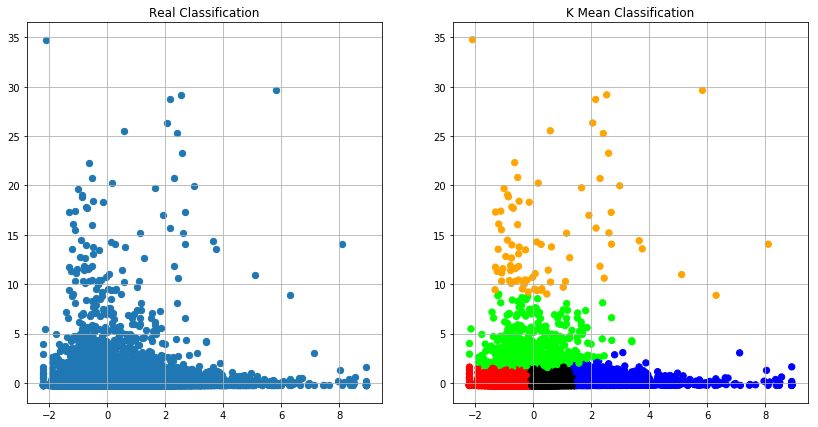

In [412]:
print model.labels_
print model.cluster_centers_
# Set the size of the plot
plt.figure(figsize=(14,7))
 
# Create a colormap
colormap = np.array(['red', 'lime', 'black','blue','orange'])
 
# Plot the Original Classifications
plt.subplot(1, 2, 1)
plt.scatter(x.household_income_2011, x.pop_density, s=40)
plt.title('Real Classification')

# Plot the Models Classifications
plt.subplot(1, 2, 2)
plt.scatter(x.household_income_2011, x.pop_density, c=colormap[model.labels_], s=40)
plt.title('K Mean Classification')

<class 'geopandas.geodataframe.GeoDataFrame'>


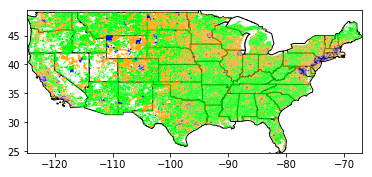

In [183]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
states_gdf.plot(ax=ax, color='white', edgecolor='black')
ax.grid(False)
top = 49.3457868 # north lat
left = -124.7844079 # west long
right = -66.9513812 # east long
bottom = 24.7433195 # south lat
ax.set_xlim([left,right])
ax.set_ylim([bottom,top])

for i in range(5):
    c = colormap[i]
    y = df.dropna()[model.labels_==i]
    y.plot(ax=ax, color=c)
x.dropna().head()
fig.savefig("us_" + str("KMEANS"))

## Analysis - Predictive Modeling
Predict future income (or other property) of a given zipcode area based on the current year.

Example shown for predicting median income in 2012 using data from 2011

/Users/ajnovack/.virtualenvs/EECS6893/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


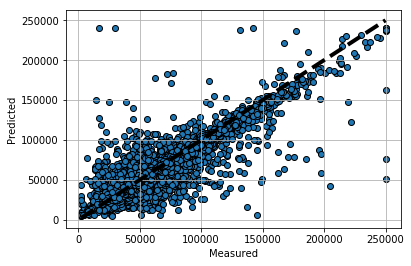

In [41]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import svm

full_df = us_gdf
lr = linear_model.LinearRegression()
y = full_df.dropna().household_income_2012

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, full_df.dropna()[["pop_density", "household_income_2011"]], y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [43]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, full_df.dropna()[["pop_density", "household_income_2011"]], y, cv=5)
print scores

[ 0.90719242  0.79687341  0.86172039  0.84246035  0.83964699]
